In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [3]:
import os

cwd = os.getcwd()
print("Current working directory: ", cwd)

Current working directory:  C:\Users\gijsd\Google Drive\Uni\AT year 3\Bachelor Assignment\thesis_code\practice


LSTM Model class

In [4]:
# Define the LSTM model
class HARLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(HARLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        # Initialize hx and cx to zeros
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)

        # Reshape input to be 3-D (sequence_length = 1) to match LSTM input shape
        x = x.unsqueeze(0)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out.squeeze(0))
        return out

Data processing, use raw data instead? Not the features

In [5]:
# Check if a GPU is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the training data
X_train = np.loadtxt('HAR_data/UCI HAR Dataset/train/X_train.txt')
Y_train = np.loadtxt('HAR_data/UCI HAR Dataset/train/y_train.txt').astype(np.int64) - 1 # Convert activity labels to 0-indexed

# Normalize the training data
X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)
X_train = (X_train - X_train_mean) / X_train_std

# Create a PyTorch TensorDataset and DataLoader for the training data
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train).float(), torch.tensor(Y_train).long())
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Load the test data
X_test = np.loadtxt('HAR_data/UCI HAR Dataset/test/X_test.txt')
Y_test = np.loadtxt('HAR_data/UCI HAR Dataset/test/y_test.txt').astype(np.int64) - 1 # Convert activity labels to 0-indexed

# Normalize the test data using the training data statistics
X_test = (X_test - X_train_mean) / X_train_std

test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test).float(), torch.tensor(Y_test).long())
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Train & Test, Hyperparameters

In [6]:
# Define the model hyperparameters, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = 64
num_classes = 6
model = HARLSTM(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Define the test function
def test(model, test_dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [7]:
# Train and test the model
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            running_loss /= 100
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss))
            running_loss = 0

    # Evaluate the model on the test data
    test_acc = test(model, test_dataloader)
    print('Testing accuracy: %.2f%%' % test_acc)

[1,   100] loss: 0.804
Testing accuracy: 90.50%
[2,   100] loss: 0.253
Testing accuracy: 92.70%
[3,   100] loss: 0.137
Testing accuracy: 93.93%
[4,   100] loss: 0.089
Testing accuracy: 93.89%
[5,   100] loss: 0.069
Testing accuracy: 94.67%


Confusion Matrix

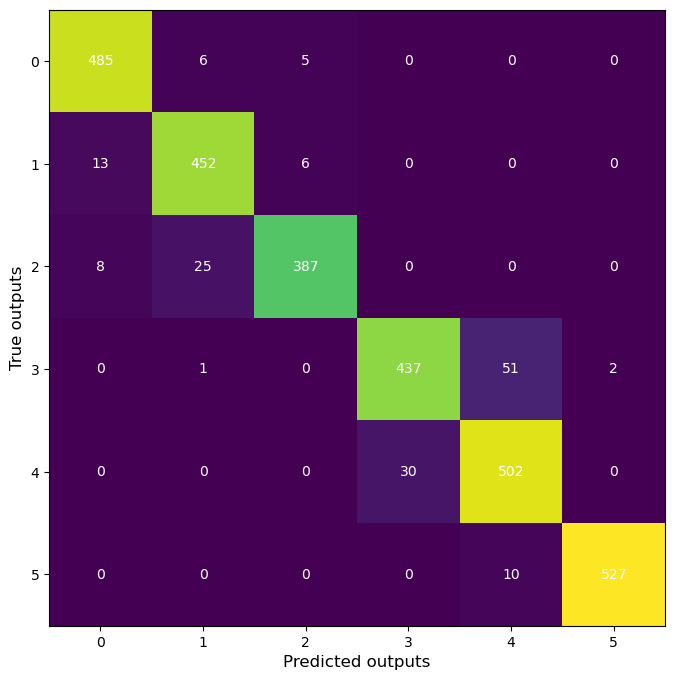

In [8]:
# Get all test samples and their true labels
test_inputs = []
test_labels = []
for inputs, labels in test_dataloader:
    test_inputs.append(inputs)
    test_labels.append(labels)
test_inputs = torch.cat(test_inputs, dim=0).to(device)
test_labels = torch.cat(test_labels, dim=0).numpy()

# Pass all test samples through the model to get their predicted labels
model.eval()
test_outputs = model(test_inputs)
_, test_predicted = torch.max(test_outputs, 1)
test_predicted = test_predicted.cpu().numpy()

# Compute the confusion matrix
confusion_mat = confusion_matrix(test_labels, test_predicted)

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(confusion_mat)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('True outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(6))
ax.yaxis.set(ticks=range(6))
ax.set_ylim(5.5, -0.5)
for i in range(6):
    for j in range(6):
        ax.text(j, i, confusion_mat[i, j], ha='center', va='center', color='white')


Visualising true labels and predicted labels

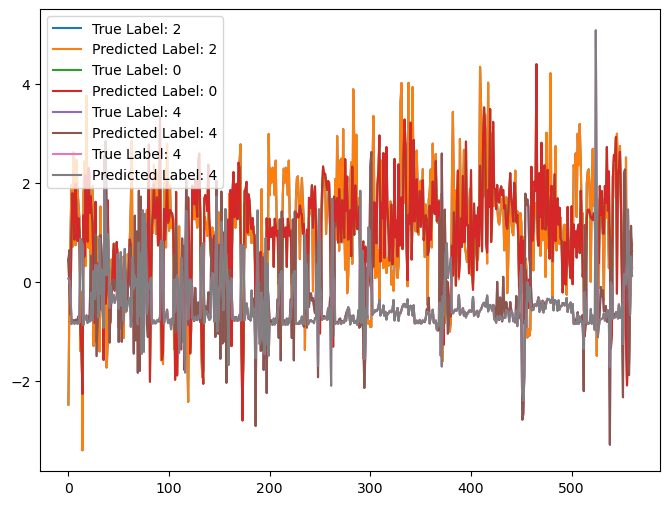

In [9]:
# Get a few test samples and their true labels
inputs, labels = next(iter(test_dataloader))
inputs = inputs.to(device)
labels = labels.numpy()

# Pass the test samples through the model to get their predicted labels
outputs = model(inputs)
_, predicted = torch.max(outputs, 1)
predicted = predicted.cpu().numpy()

# Plot the test data along with their predicted labels
plt.figure(figsize=(8, 6))
for i in range(4):#range(inputs.shape[0]):
    plt.plot(inputs[i].cpu().numpy(), label='True Label: {}'.format(labels[i]))
    plt.plot(inputs[i].cpu().numpy(), label='Predicted Label: {}'.format(predicted[i]))
plt.legend()
plt.show()